In [1]:
from utils.generic_utils import *
from utils.basic_modules import *
from utils.UEA_utils import *

#from SMATE_model import *
%run SMATE_model.ipynb

import time, os, math
import pydot, pydotplus
import numpy as np
import pandas as pd
import random as rd
import tensorflow as tf
import tensorflow.keras.layers as ll
import tensorflow.keras.backend as K

from decimal import Decimal
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Conv3D, TimeDistributed
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, add, GaussianNoise, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.losses import mse, binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import to_categorical, plot_model, multi_gpu_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm, neighbors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.core.protobuf import rewriter_config_pb2

K.clear_session()
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
off = rewriter_config_pb2.RewriterConfig.OFF
config.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.Session(config=config)
K.set_session(sess)



In [2]:
UEA_MTS_List = [
        "ArticularyWordRecognition",
        "AtrialFibrillation",
        "BasicMotions",
        "CharacterTrajectories",
        "Cricket", #5
        #"DuckDuckGeese",
        #"EigenWorms",
        "Epilepsy",
        "EthanolConcentration",
        "ERing",#10
        "FaceDetection",
        "FingerMovements",
        "HandMovementDirection",
        #"Handwriting",
        "Heartbeat",#15
        #"InsectWingbeat",
        #"JapaneseVowels",
        #"Libras",
        "LSST",
        "MotorImagery",#20
        "NATOPS",
        "PenDigits",
        "PEMS-SF",
        "PhonemeSpectra",
        #"RacketSports",#25
        "SelfRegulationSCP1",
        "SelfRegulationSCP2",
        "SpokenArabicDigits",
        "StandWalkJump",        
        #"UWaveGestureLibrary"
]

hyper_paras_map = {
        "ArticularyWordRecognition" : [10, 4], 
        "AtrialFibrillation" : [64, 2],
        "BasicMotions" : [10, 2],
        "CharacterTrajectories" : [30, 2],
        "Cricket" : [100, 4], #5
        #"DuckDuckGeese",
        #"EigenWorms",
        "Epilepsy" : [30, 2],
        "EthanolConcentration" : [50, 2],  
        "ERing": [5, 4],#10
        "FaceDetection" : [8, 16],  
        "FingerMovements" : [5, 8],  
        "HandMovementDirection" : [40, 4],  
        #"Handwriting",
        "Heartbeat" : [5, 16],  #15
        #"InsectWingbeat",
        #"JapaneseVowels",
        #"Libras",
        "LSST" : [4, 4],  
        "MotorImagery" : [100, 8],  #20
        "NATOPS" : [3, 6],
        "PenDigits" : [2, 2],
        "PEMS-SF" : [10, 64],  
        "PhonemeSpectra" : [30, 4],  
        #"RacketSports",#25
        "SelfRegulationSCP1" : [100, 6],  
        "SelfRegulationSCP2" : [100, 6],  
        "SpokenArabicDigits" : [10, 4],  
        "StandWalkJump" : [100, 4],        
        #"UWaveGestureLibrary"
}


sup_ratio = 1 # the supervised ratio in training set, 1 by defaut (fully supervised)
n_epochs = 500


---
Input Data format (MTS-others)
---

A single file contains all samples and their labels: ***L * (3 + D)***



- 1st col: sample_id
- 2nd col: timestamps
- 3rd col: label
- after the 4th col: mts vector with D dimensions   


In [3]:
'''=================================================== Prepare data ========================================================'''
## Prepare UEA data
rep_main = "../Datasets/MTS-UEA/"
ds_name = "SelfRegulationSCP1"
# Two hyper-parameters vary with datasets
pool_step = hyper_paras_map[ds_name][0]
d_prime = hyper_paras_map[ds_name][1]
rep_ds_train = rep_main + ds_name + "/output_train/"
rep_ds_test = rep_main + ds_name + "/output_test/"
meta_csv = "meta_data.csv"  # the meta data of training/testing set
rep_output = rep_ds_train + "out_results/"  # output results, e.g., training loss, models
os.system("mkdir -p " + rep_output)

dataset = get_UEA_dataset(rep_ds_train, rep_ds_test, meta_csv, sup_ratio, mode='load')


x_train = dataset['X_train']
y_train = dataset['Y_train']
x_test = dataset['X_test']
y_test = dataset['Y_test']
x_sup = dataset['X_sup']  # 3-D Array: N * L * D
x_unsup = dataset['X_unsup']
y_sup = dataset['Y_sup']  # 1-D Array
y_unsup = dataset['Y_unsup']


# Bacis Dataset Information and Model Configurations
train_size = x_train.shape[0] 
L = x_train.shape[1]
data_dim = x_train.shape[2]
n_class = dataset['n_classes']
label_size = x_sup.shape[0]
unlabel_size = x_unsup.shape[0]

print("n_train is", train_size, "; n_test =", x_test.shape[0], "; L =", L, "; D =", data_dim, 
      "; n_class =",n_class)


class list is ['negativity' 'positivity']
total number of samples is 268
total number of samples is 293
n_train is 268 ; n_test = 293 ; L = 896 ; D = 6 ; n_class = 2


In [4]:
# Build SMATE model
smate = SMATE(L, data_dim, n_class, label_size, unlabel_size, 
              y_sup, sup_ratio, pool_step, d_prime)

smate.build_model("step_1")
#smate.model.summary()
# Train SMATE model
t1 = time.time()
smate.fit(n_epochs, x_train, x_sup, x_unsup)
print("training time is {}".format(time.time() - t1))

W0611 23:11:50.331722 22372510828352 deprecation_wrapper.py:119] From /gpfsdswork/projects/rech/pch/ulz67kb/SMATE_MTS/utils/basic_modules.py:60: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.

W0611 23:11:50.335011 22372510828352 deprecation.py:506] From /linkhome/rech/genvsq01/ulz67kb/.conda/envs/SMAT_ADE/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0611 23:11:54.106565 22372510828352 training_utils.py:1101] Output dense_8 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_8.
W0611 23:11:54.142791 22372510828352 deprecation.py:323] From /linkhome/rech/genvsq01/ul

n_epochs=500, batch_size=268, n_sup=268, n_sup=0, steps=500


/linkhome/rech/genvsq01/ulz67kb/.conda/envs/SMAT_ADE/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/500
268/268 [==============================] - 4s 14ms/sample - loss: 31.9191
Epoch 2/500
268/268 [==============================] - 0s 1ms/sample - loss: 31.6070
Epoch 3/500
268/268 [==============================] - 0s 1ms/sample - loss: 31.2932
Epoch 4/500
268/268 [==============================] - 0s 998us/sample - loss: 30.9790
Epoch 5/500
268/268 [==============================] - 0s 1ms/sample - loss: 30.6648
Epoch 6/500
268/268 [==============================] - 0s 1ms/sample - loss: 30.3512
Epoch 7/500
268/268 [==============================] - 0s 1ms/sample - loss: 30.0396
Epoch 8/500
268/268 [==============================] - 0s 1ms/sample - loss: 29.7311
Epoch 9/500
268/268 [==============================] - 0s 1ms/sample - loss: 29.4250
Epoch 10/500
268/268 [==============================] - 0s 1ms/sample - loss: 29.1211
Epoch 11/500
268/268 [==============================] - 0s 1ms/sample - loss: 28.8196
Epoch 12/500
268/268 [==============================] - 0s 1

Epoch 97/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.6390
Epoch 98/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.6162
Epoch 99/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.5937
Epoch 100/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.5716
Epoch 101/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.5498
Epoch 102/500
268/268 [==============================] - 0s 1000us/sample - loss: 19.5284
Epoch 103/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.5072
Epoch 104/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.4864
Epoch 105/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.4658
Epoch 106/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.4456
Epoch 107/500
268/268 [==============================] - 0s 1ms/sample - loss: 19.4256
Epoch 108/500
268/268 [====================

268/268 [==============================] - 0s 1ms/sample - loss: 18.3804
Epoch 192/500
268/268 [==============================] - 0s 1000us/sample - loss: 18.3726
Epoch 193/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3648
Epoch 194/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3572
Epoch 195/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3495
Epoch 196/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3420
Epoch 197/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3345
Epoch 198/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3270
Epoch 199/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3196
Epoch 200/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3123
Epoch 201/500
268/268 [==============================] - 0s 1ms/sample - loss: 18.3050
Epoch 202/500
268/268 [==============================]

268/268 [==============================] - 0s 1ms/sample - loss: 17.8322
Epoch 286/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.8277
Epoch 287/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.8233
Epoch 288/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.8188
Epoch 289/500
268/268 [==============================] - 0s 998us/sample - loss: 17.8144
Epoch 290/500
268/268 [==============================] - 0s 996us/sample - loss: 17.8099
Epoch 291/500
268/268 [==============================] - 0s 998us/sample - loss: 17.8055
Epoch 292/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.8011
Epoch 293/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.7968
Epoch 294/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.7924
Epoch 295/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.7881
Epoch 296/500
268/268 [============================

Epoch 379/500
268/268 [==============================] - 0s 996us/sample - loss: 17.4647
Epoch 380/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.4613
Epoch 381/500
268/268 [==============================] - 0s 1000us/sample - loss: 17.4578
Epoch 382/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.4543
Epoch 383/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.4509
Epoch 384/500
268/268 [==============================] - 0s 1000us/sample - loss: 17.4474
Epoch 385/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.4440
Epoch 386/500
268/268 [==============================] - 0s 993us/sample - loss: 17.4406
Epoch 387/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.4372
Epoch 388/500
268/268 [==============================] - 0s 995us/sample - loss: 17.4337
Epoch 389/500
268/268 [==============================] - 0s 995us/sample - loss: 17.4303
Epoch 390/500
268/268 [======

Epoch 473/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1658
Epoch 474/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1629
Epoch 475/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1600
Epoch 476/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1571
Epoch 477/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1542
Epoch 478/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1514
Epoch 479/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1485
Epoch 480/500
268/268 [==============================] - 0s 996us/sample - loss: 17.1456
Epoch 481/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1428
Epoch 482/500
268/268 [==============================] - 0s 1ms/sample - loss: 17.1399
Epoch 483/500
268/268 [==============================] - 0s 999us/sample - loss: 17.1371
Epoch 484/500
268/268 [================

In [6]:
# Test SMATE model on both supervised and semi-supervised classification
smate.predict(x_train, y_train, x_test, y_test)
#smate.predict_ssl(x_sup, y_sup, x_unsup, y_unsup, x_test, y_test) #semi-supervised prediction


acc_svm is  0.7849829351535836 acc_svm_linear is  0.7918088737201365


step_1: raw embedding space with Centroids Initialization (train & test)
141
drawing ...


'tSNE_plot("step_1", dataset_info, d_prime, h_center, h_train, h_label, \n              h_unlabel, h_test, y_train, y_label, y_unlabel, y_test)\n\ntSNE_plot("step_3", dataset_info, d_prime, h_center, h_train, h_label, \n              h_unlabel, h_test, y_train, y_label, y_unlabel, y_test)\n'

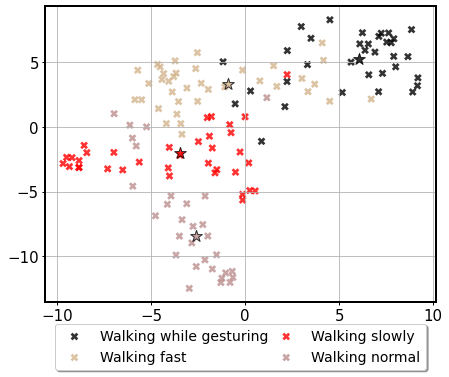

In [58]:
%run utils/data_plot.ipynb

h_train = smate.model_e.predict(x_train)
h_test = smate.model_e.predict(x_test)
# reshape
h_train = np.reshape(h_train, (h_train.shape[0], h_train.shape[1]*h_train.shape[2]))
h_test = np.reshape(h_test, (h_test.shape[0], h_test.shape[1]*h_test.shape[2]))

h_label = h_train[: label_size]
h_unlabel = h_train[label_size :]
y_label = y_sup
y_unlabel = y_unsup

hidden_dim = 128

''' ********* Information for plotting the embedding space *********'''
proto_list = []
n_class = len(np.unique(y_train))
for i in range(n_class):
    idx = np.where(y_train == i)[0]
    # compute the central point of each class
    class_repr = np.mean(h_train[idx], axis=0)  # 1 * L
    proto_list.append(class_repr) # n_class * L
h_center = np.array(proto_list)
        
        
dataset_info = (ds_name, n_class, train_size, h_center.shape[1])

tSNE_plot("step_1", dataset_info, d_prime, h_center, h_train, h_label, 
              h_unlabel, h_test, y_train, y_label, y_unlabel, y_test)
'''tSNE_plot("step_1", dataset_info, d_prime, h_center, h_train, h_label, 
              h_unlabel, h_test, y_train, y_label, y_unlabel, y_test)

tSNE_plot("step_3", dataset_info, d_prime, h_center, h_train, h_label, 
              h_unlabel, h_test, y_train, y_label, y_unlabel, y_test)
'''

In [7]:
 def tSNE_plot_embeddings(self, ds_name, hidden_dim, x_train, y_train, x_test, y_test):
        h_train = self.model_e.predict(x_train)
        h_test = self.model_e.predict(x_test)

        h_train = np.reshape(h_train, (h_train.shape[0], h_train.shape[1]*h_train.shape[2]))
        h_test = np.reshape(h_test, (h_test.shape[0], h_test.shape[1]*h_test.shape[2]))
        
        ''' ********* Information for plotting the embedding space *********'''
        proto_list = []
        n_class = len(np.unique(y_train))
        for i in range(n_class):
            idx = np.where(y_train == i)[0]
            # compute the central point of each class
            class_repr = np.mean(h_train[idx], axis=0)  # 1 * L
            proto_list.append(class_repr) # n_classes * L
        h_center = np.array(proto_list)
        
        dataset_info = (ds_name, self.n_classes, hidden_dim*self.d_prime)
        
        self.L = L
        self.data_dim = data_dim
        self.n_classes = n_classes
        self.label_size = label_size
        self.unlabel_size = unlabel_size
        self.train_size = label_size + unlabel_size
        self.y_sup = y_sup
        self.sup_ratio = sup_ratio
        self.pool_step = pool_step
        self.d_prime = d_prime
        
        tSNE_plot(style="step_1", dataset_info, self.d_prime, h_center, h_train, h_label, 
              h_unlabel, h_test, y_train, y_label, y_unlabel, y_test)
        

SyntaxError: positional argument follows keyword argument (<ipython-input-7-db69561cbe47>, line 31)